# Маркетинговая аналитика для Яндекс.Афиши

# Описание проекта

- Заказчик проекта — отдел маркетинговой аналитики Яндекс.Афиши.
- Задача проекта — снизить расходы маркетологов, отказавшись от неокупающихся источников трафика и перераспределив бюджет. Для этого необходимо изучить:
    - как клиенты пользуются сервисом Яндекс.Афиши, 
    - когда они делают первые покупки на сайте, 
    - сколько денег приносит компании каждый из клиентов, 
    - когда окупаются расходы на привлечение клиента.

# Описание и структура данных

Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:

Файл visits_log.csv хранит лог сервера с информацией о посещениях сайта.
- Структура visits_log.csv: 
    - Uid — уникальный идентификатор пользователя,
    - Device — категория устройства пользователя,
    - Start Ts — дата и время начала сессии,
    - End Ts — дата и время окончания сессии,
    - Source Id — идентификатор источника перехода на сайт.


Файл orders_log.csv хранит выгрузку всех заказов за период.
- Структура orders_log.csv
    - Uid — уникальный идентификатор пользователя,
    - Buy Ts — дата и время заказа,
    - Revenue — сумма заказа (выручка измеряется в условных единицах — у.е.)

Файл costs.csv хранит информацию о расходах на маркетинг.
- Структура costs.csv
    - source_id — идентификатор рекламного источника,
    - dt — дата проведения рекламной кампании,
    - costs — расходы на эту кампанию.

# Содержание

1. [Шаг 1. Загрузка датасета и подготовка его к анализу](#start)
    * [Вывод](#start_total)
2. [Шаг 2. Расчет метрик и построение графиков](#metrics)
    * [Продуктовые метрики](#product_metrics)
    * [Метрики электронной коммерции](#commercial_metrics)
    * [Маркетинговые метрики](#marketing_metrics)
3. [Выводы и рекомендации](#total)

## Шаг 1. Загрузка датасета и подготовка его к анализу<a id="start"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import numpy as np
import math
from scipy import stats as st
from functools import reduce
from IPython.display import display


visits = pd.read_csv('.../visits_log.csv')

orders = pd.read_csv('.../orders_log.csv')

costs = pd.read_csv('.../costs.csv')

# <Меняем регистр названий столбцов>
visits.columns = map(str.lower, visits.columns)
orders.columns = map(str.lower, orders.columns)
costs.columns = map(str.lower, costs.columns)

In [2]:
visits

,device,end ts,source id,start ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485


In [3]:
orders

,buy ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247


In [4]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [5]:
# <Переименовываем названия столбцов для удобства>
visits = visits.rename(columns={'start ts': 'start_ts', 'end ts': 'end_ts','source id': 'source_id'})
orders = orders.rename(columns={'buy ts': 'buy_ts'})

In [6]:
costs['source_id'].value_counts()

5     364
9     363
3     363
1     363
10    363
4     363
2     363
Name: source_id, dtype: int64

In [7]:
# <С учетом того, что из 6 и 7 источника пришло всего 36 и 6 пользователей, удаляем эти данные, рекламных бюджетов 
#  на эти источники также не предусмотрено в таблице costs>

visits= visits.query('source_id != 7 and source_id != 6')
visits['source_id'].value_counts()

4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
Name: source_id, dtype: int64

### Таблицы visits и orders: подготовка данных

In [8]:
# <Приводим к формату даты столбцы>

visits['source_id'].astype('int')
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [9]:
visits.isnull().sum()

device       0
end_ts       0
source_id    0
start_ts     0
uid          0
dtype: int64

In [10]:
orders.isnull().sum()

buy_ts     0
revenue    0
uid        0
dtype: int64

In [11]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359358 entries, 0 to 359399
Data columns (total 5 columns):
device       359358 non-null object
end_ts       359358 non-null datetime64[ns]
source_id    359358 non-null int64
start_ts     359358 non-null datetime64[ns]
uid          359358 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 16.5+ MB


In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [13]:
visits.duplicated(keep = False).sum()

0

In [14]:
orders.duplicated(keep = False).sum()

0

### Таблица costs: подготовка данных

In [15]:
# <Приводим к необходимым форматам столбцы датафрейма costs>
costs['source_id'].astype('int')
costs['dt'] = pd.to_datetime(costs['dt'])
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [16]:
costs.isnull().sum()

source_id    0
dt           0
costs        0
dtype: int64

In [17]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [18]:
costs.duplicated(keep = False).sum()

0

In [19]:
print('Начало временного интервала visits: ', visits['start_ts'].min())
print('Конец временного интервала visits: ', visits['end_ts'].max())

print()
print('Начало временного интервала orders: ', orders['buy_ts'].min())
print('Конец временного интервала orders: ', orders['buy_ts'].max())

print()
print('Начало временного интервала costs: ', costs['dt'].min())
print('Конец временного интервала costs: ', costs['dt'].max())


# <Требуются данные с июня 2017 по май 2018 года, поэтому удаляем данные за июнь 2018 года'>
visits = visits[visits['end_ts'] < '2018-06-01']
orders = orders[orders['buy_ts'] < '2018-06-01']

Начало временного интервала visits:  2017-06-01 00:01:00
Конец временного интервала visits:  2018-06-01 01:26:00

Начало временного интервала orders:  2017-06-01 00:10:00
Конец временного интервала orders:  2018-06-01 00:02:00

Начало временного интервала costs:  2017-06-01 00:00:00
Конец временного интервала costs:  2018-05-31 00:00:00


In [20]:
print('Конец временного интервала visits: ', visits['end_ts'].max())
print('Конец временного интервала orders: ', orders['buy_ts'].max())

Конец временного интервала visits:  2018-05-31 23:59:00
Конец временного интервала orders:  2018-05-31 23:56:00


Поскольку для данного проекта требуются данные с июня 2017 по май 2018 года, удаляем данные за июнь 2018 года, также находящиеся в датасете

In [21]:
# <Преобразование строковой переменной в категориальную сэкономит некоторую память: меняем тип данных у device на category>
visits['device'].astype('category')
visits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359346 entries, 0 to 359399
Data columns (total 5 columns):
device       359346 non-null object
end_ts       359346 non-null datetime64[ns]
source_id    359346 non-null int64
start_ts     359346 non-null datetime64[ns]
uid          359346 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 16.4+ MB


In [22]:
# <Рассмотрим, какие есть источники трафика>
costs.groupby('source_id').agg({'costs':'sum'}).sort_values(by= ['costs'], ascending=False)

,costs
source_id,
3,141321.63
4,61073.60
5,51757.10
2,42806.04
1,20833.27
10,5822.49
9,5517.49


У нас есть 7 рекламных источников, наиболее затратный - под номером 3

### Вывод<a id="start_total"></a>

- Дубликатов и пропусков в таблицах visits, orders и costs не обнаружено.

- Привели к формату даты столбцы start_ts, end_ts, buy_ts и dt с помощью метода to_datetime()

- Удалили ненужные для проекта данные за июнь 2018 года, также находящиеся в датасете

- Изменили строковый тип данных в столбце device на category - это сэкономит некоторую память

- Изучили, какие есть источники трафика: у нас есть 7 рекламных источников, наиболее затратный из них - под номером 3

## Шаг 2. Расчет метрик и построение графиков<a id="metrics"></a>

### Продуктовые метрики <a id="product_metrics"></a>

#### Рассчитайте DAU, WAU и MAU. Вычислите средние значения этих метрик за весь период. Отобразите изменения метрик во времени на графиках

In [23]:
# <Получаем столбцы с годом, месяцем, неделей и датой первого посещения сайта>

visits['session_date']  = visits['start_ts'].astype('datetime64[D]')
visits['session_year']  = visits['start_ts'].astype('datetime64[Y]')
visits['session_month'] = visits['start_ts'].astype('datetime64[M]') 
visits['session_week']  = visits['start_ts'].astype('datetime64[W]')

visits['session_month_count'] = visits['session_month'].dt.month


orders['order_date']  = orders['buy_ts'].astype('datetime64[D]')
orders['order_month'] = orders['order_date'].astype('datetime64[M]')

# DAU - количество уникальных пользователей в день, от англ. daily active users 
DAU = visits.groupby('session_date').agg({'uid':'nunique'}).mean()

# WAU - количество уникальных пользователей в неделю, от англ. weekly active users
WAU = visits.groupby(['session_year', 'session_week']).agg({'uid':'nunique'}).mean()

# MAU - количество уникальных пользователей в месяц, от англ. monthly active users
MAU = visits.groupby(['session_year', 'session_month']).agg({'uid':'nunique'}).mean()
 
print ('DAU:', DAU)
print ('WAU:', WAU)
print ('MAU:', MAU)

DAU: uid    907.85989
dtype: float64
WAU: uid    5620.851852
dtype: float64
MAU: uid    23225.0
dtype: float64


- В день - 908 уникальных пользователей (в среднем)
- В неделю - 5716 уникальных пользователей (в среднем)
- В месяц - 23228 уникальных пользователей (в среднем)

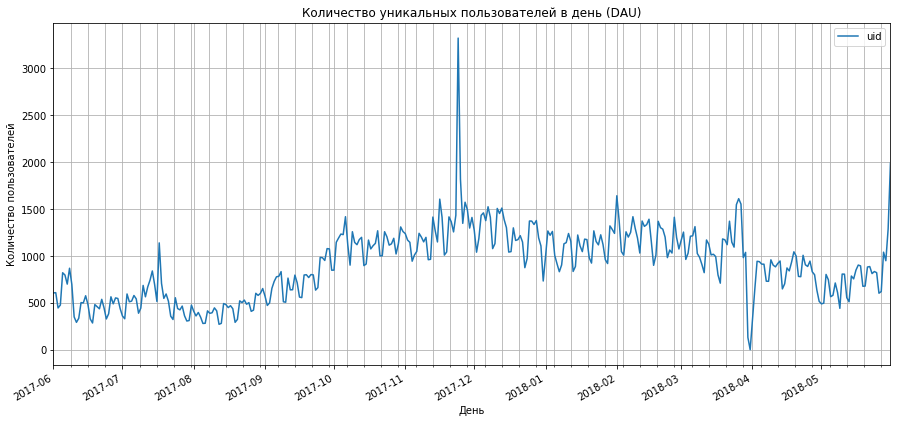

In [24]:
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['axes.grid.which'] = 'both'
matplotlib.rcParams['xtick.minor.visible'] = True

# <Строим график количества уникальных пользователей в день>
dau_graph = visits.groupby('session_date').agg({'uid':'nunique'}).plot(figsize = (15,7))
plt.title('Количество уникальных пользователей в день (DAU)')
plt.ylabel('Количество пользователей')
plt.xlabel('День')
plt.show()

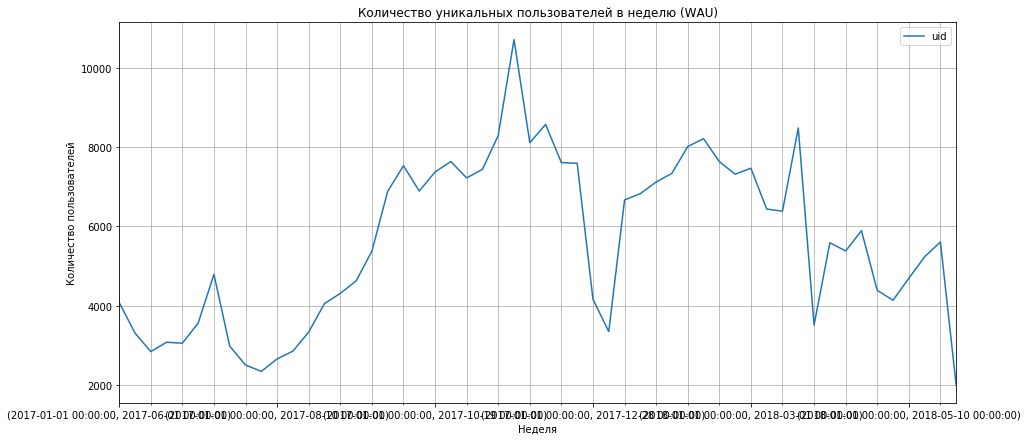

In [25]:
wau_graph = visits.groupby(['session_year', 'session_week']).agg({'uid':'nunique'}).plot(figsize = (15,7))
plt.title('Количество уникальных пользователей в неделю (WAU)')
plt.ylabel('Количество пользователей')
plt.xlabel('Неделя')
plt.show()

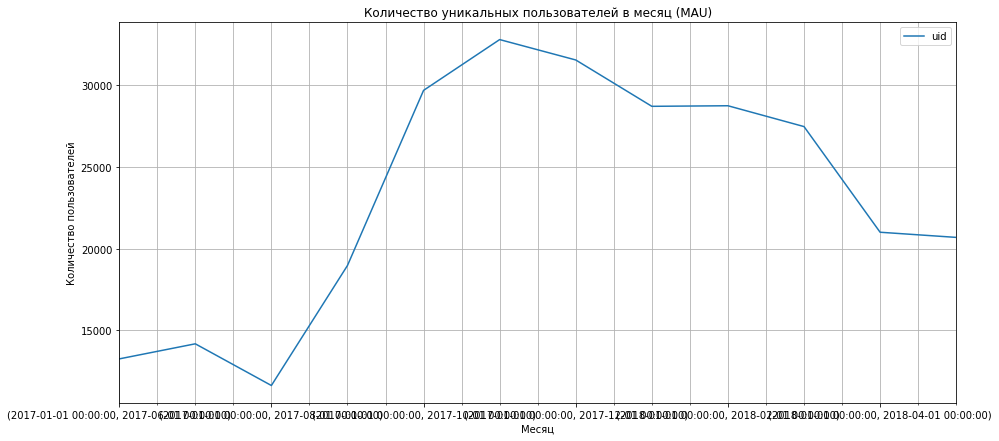

In [26]:
mau_graph = visits.groupby(['session_year', 'session_month']).agg({'uid':'nunique'}).plot(figsize = (15,7))
plt.title('Количество уникальных пользователей в месяц (MAU)')
plt.ylabel('Количество пользователей')
plt.xlabel('Месяц')
plt.show()

Согласно графику количество пользователей на сайте увеличивается к зиме, а летом снижается

На графике виден один пик в ноябре 2017 года и один явный минимум в конце марта 2018 года. Возможно, пик связан с черной пятницей в ноябре, проверим, так ли это

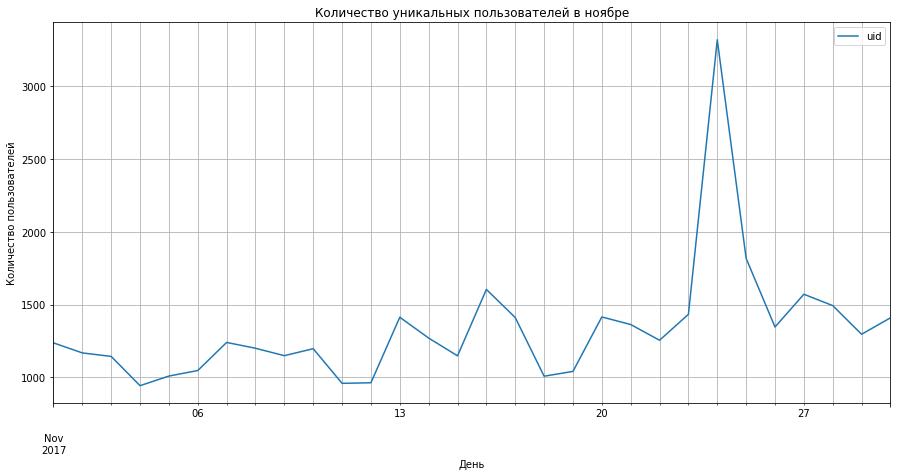

In [27]:
visits_november = visits.query('session_month_count == 11')
visits_november.groupby('session_date').agg({'uid':'nunique'}).plot(figsize = (15,7))
plt.title('Количество уникальных пользователей в ноябре')
plt.ylabel('Количество пользователей')
plt.xlabel('День')
plt.show()

Пик уникальных пользователей в день приходится на 2017-11-24, в 2017 году это и есть черная пятница, соответственно, это нельзя считать выбросом

#### Определите, сколько раз за день пользователи в среднем заходят на сайт. Постройте график, отражающий изменения метрики во времени

In [28]:
daily_sessions = visits.groupby('session_date').agg({'uid': ['count','nunique']}).reset_index()
daily_sessions.columns = ['session_date', 'uid_count', 'uid_nunique']
daily_sessions['sessions_count'] = daily_sessions['uid_count']/daily_sessions['uid_nunique']
daily_sessions['sessions_count'].describe()

count    364.000000
mean       1.082168
std        0.020877
min        1.000000
25%        1.070321
50%        1.082488
75%        1.093896
max        1.217837
Name: sessions_count, dtype: float64

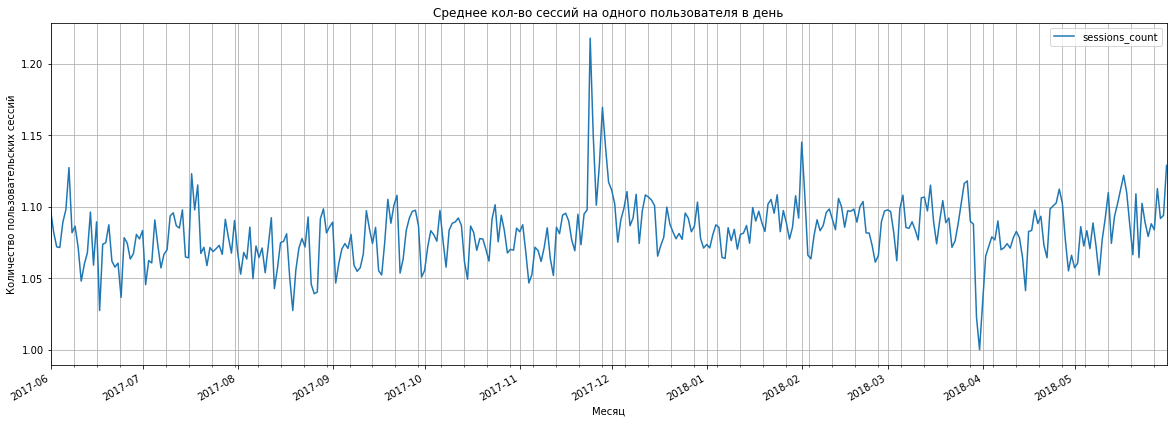

In [29]:
daily_sessions.plot(x='session_date', y='sessions_count', title='Среднее кол-во сессий на одного пользователя в день', figsize=(20, 7))
plt.ylabel('Количество пользовательских сессий')
plt.xlabel('Месяц')
plt.show()

In [30]:
# <Находим среднее количество сессий на пользователя за год>
daily_sessions['sessions_count'].mean()

1.082168242468012

В среднем на одного пользователя приходится 1 сессия в день, повторно на сайт пользователи не заходят

#### Исследуйте, сколько времени пользователи проводят на сайте. Узнайте продолжительность типичной пользовательской сессии за весь период. Чтобы выбрать подходящую среднюю меру, постройте график распределения. Изменение продолжительности сессий во времени изучать необязательно

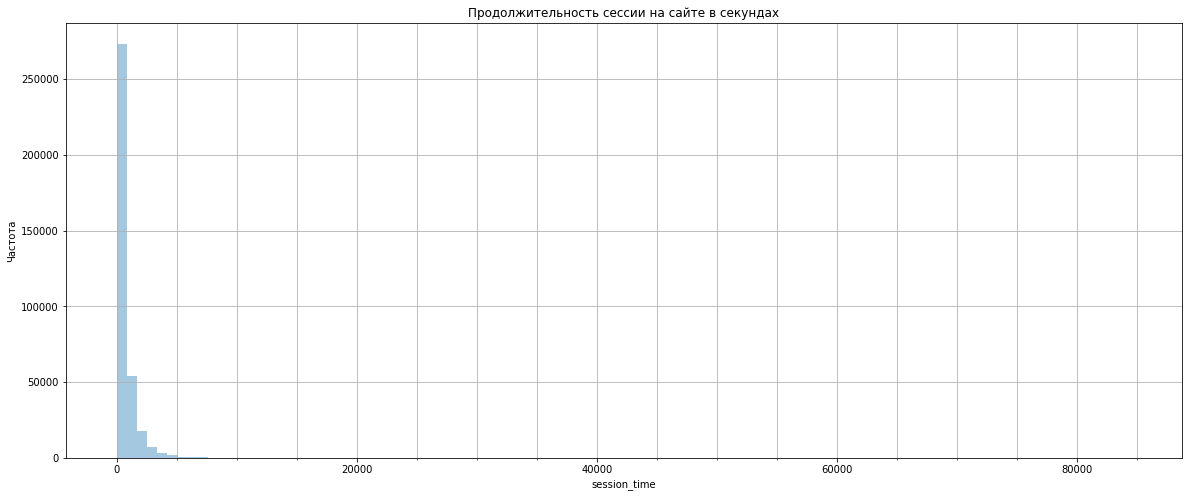

In [31]:
# <Создаем столбец с продолжительностью сессии на сайте в секундах>
visits['time_spent'] = visits['end_ts'] - visits['start_ts']
visits['time_spent'] = pd.to_datetime(visits['time_spent'])

visits['session_time'] = (visits['time_spent'].dt.hour * 3600 
                          + visits['time_spent'].dt.minute * 60 
                          + visits['time_spent'].dt.second
                         )

plt.figure(figsize=(20, 8))
plt.title('Продолжительность сессии на сайте в секундах')
plt.ylabel('Частота')
plt.xlabel('Количество секунд')
sns.distplot(visits['session_time'], kde = False, bins = 100)
plt.show()

In [32]:
visits['session_time'].mean()

643.4572584639874

In [33]:
visits['session_time'].median()

300.0

На диаграмме видна скошенность набора данных, поэтому используем медиану для подсчета продолжительности типичной пользовательской сессии. 
Продолжительность сессии равна 300 секундам или 5 минутам

#### Рассчитайте Retention Rate, применяя когортный анализ. Покажите изменения метрики во времени на графике. Найдите средний Retention Rate на второй месяц «жизни» когорт.

In [34]:
# <С помощью groupby создаем столбец с датой первого посещения сайта "first_session" и приводим столбцы к 'datetime64[M]'>

first_session = visits.groupby(['uid'])['session_date'].min()
first_session.name = 'first_session'

visits = visits.join(first_session, on='uid')

visits['first_session_month'] = visits['first_session'].astype('datetime64[M]')
visits['session_month'] = visits['session_date'].astype('datetime64[M]')

In [35]:
# <Создаем столбец с "продолжительностью жизни" когорт и приводим к int>

visits['cohort_lifetime'] = (visits['session_month'] - visits['first_session_month'])

visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1, 'M')

visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int') 
visits

,device,end_ts,source_id,start_ts,uid,session_date,session_year,session_month,session_week,session_month_count,time_spent,session_time,first_session,first_session_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-01-01,2017-12-01,2017-12-14,12,1970-01-01 00:18:00,1080,2017-12-20,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-01-01,2018-02-01,2018-02-15,2,1970-01-01 00:28:00,1680,2018-02-19,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-01-01,2017-07-01,2017-06-29,7,1970-01-01 00:00:00,0,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-01-01,2018-05-01,2018-05-17,5,1970-01-01 00:24:00,1440,2018-03-09,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-01-01,2017-12-01,2017-12-21,12,1970-01-01 00:00:00,0,2017-12-27,2017-12-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-29,2017-01-01,2017-07-01,2017-07-27,7,1970-01-01 00:00:19,19,2017-07-29,2017-07-01,0
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-25,2018-01-01,2018-01-01,2018-01-25,1,1970-01-01 00:00:19,19,2018-01-25,2018-01-01,0
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-03,2018-01-01,2018-03-01,2018-03-01,3,1970-01-01 00:00:19,19,2018-03-03,2018-03-01,0
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-02,2017-01-01,2017-11-01,2017-11-02,11,1970-01-01 00:00:19,19,2017-11-02,2017-11-01,0


In [36]:
# <Группируем, чтобы посчитать количество пользователей каждой когорты на каждый месяц "жизни" когорты>

cohorts = visits.groupby(['first_session_month', 'cohort_lifetime']).agg(
    {'uid': 'nunique'}).reset_index() 

cohorts

,first_session_month,cohort_lifetime,uid
0,2017-06-01,0,13257
1,2017-06-01,1,1043
2,2017-06-01,2,712
3,2017-06-01,3,814
4,2017-06-01,4,909
...,...,...,...
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15708
76,2018-04-01,1,760


In [37]:
# <Создаем столбец cohort_users, в котором посчитано количество пользователей на первый месяц жизни когорты >

initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_session_month', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 
cohorts = cohorts.merge(initial_users_count, on='first_session_month') 

# <Столбец retention показывает, 
# сколько пользователей из когорты относительно их изначального числа вернулось в последующие периоды>

cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] 
cohorts

,first_session_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13257,13257,1.000000
1,2017-06-01,1,1043,13257,0.078675
2,2017-06-01,2,712,13257,0.053707
3,2017-06-01,3,814,13257,0.061402
4,2017-06-01,4,909,13257,0.068568
...,...,...,...,...,...
73,2018-03-01,1,861,20588,0.041820
74,2018-03-01,2,557,20588,0.027055
75,2018-04-01,0,15708,15708,1.000000
76,2018-04-01,1,760,15708,0.048383


In [38]:
# <Создаем сводную таблицу с retention rate на каждый месяц жизни каждой когорты >

retention_pivot = cohorts.pivot_table(
    index='first_session_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
)
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06-01,1.0,0.078675,0.053707,0.061402,0.068568,0.071434,0.061024,0.057781,0.052350,0.050841,0.040658,0.044957
2017-07-01,1.0,0.056101,0.051305,0.056177,0.058232,0.048185,0.045368,0.045749,0.038822,0.028621,0.027480,NaN
2017-08-01,1.0,0.076817,0.062868,0.062770,0.050098,0.044008,0.036346,0.039489,0.027898,0.026031,NaN,NaN
2017-09-01,1.0,0.085499,0.069213,0.050712,0.039396,0.037840,0.035864,0.024189,0.022812,NaN,NaN,NaN
2017-10-01,1.0,0.078620,0.052247,0.038925,0.034266,0.032226,0.021368,0.020367,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078284,0.044115,0.038683,0.033728,0.023415,0.021801,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055822,0.037967,0.031118,0.020270,0.019043,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059723,0.039344,0.024977,0.020247,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057082,0.025455,0.020094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


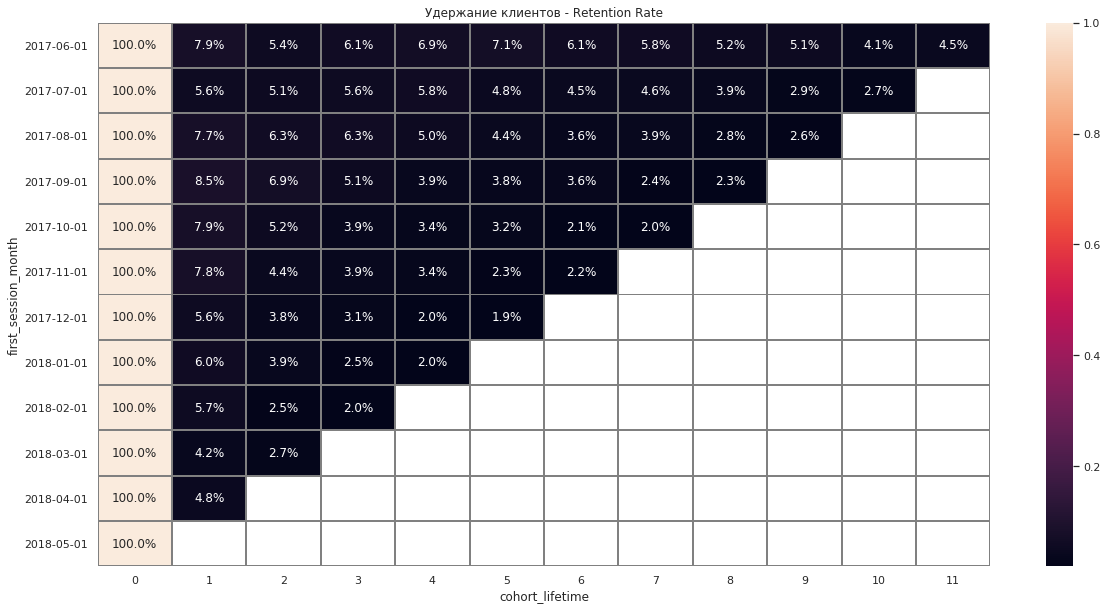

In [39]:
# <Визуализируем сводную таблицу с retention rate с помощью heatmap>

sns.set(style='white')
plt.figure(figsize=(20, 10))
plt.title('Удержание клиентов - Retention Rate')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', 
            yticklabels=retention_pivot.index.strftime('%Y-%m-%d'))


In [40]:
# <Считаем retention rate для второго месяца жизни когорт>
retention_pivot[1].mean()*100

6.516611527402606

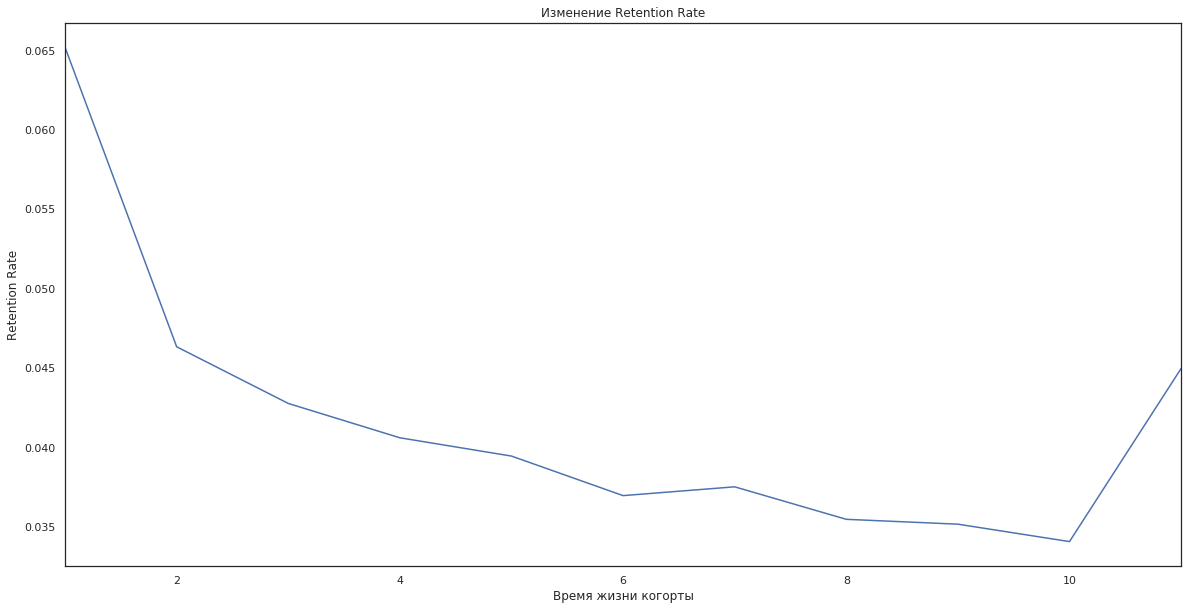

In [41]:
# <Создаем график >
retention_pivot[[1, 2, 3, 4, 5, 6 ,7, 8, 9, 10, 11]].mean().plot(figsize = (20,10))
plt.title('Изменение Retention Rate')
plt.ylabel('Retention Rate')
plt.xlabel('Время жизни когорты')
plt.show()

Показатель Retention Rate за второй месяц жизни когорт равен 6,5%, и он больше показателей Retention Rate за все остальные месяцы, соответственно с течением времени показатель Retention Rate снижается

В последнем месяце увеличивается retention rate из-за того, что показатель рассчитывается только по одной (первой) когорте

### Метрики электронной коммерции <a id="commercial_metrics"></a>

#### Исследуйте, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки. Изучать изменение этой метрики во времени необязательно

In [43]:
first_orders_time_to_buy = orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
first_visits_time_to_buy = visits.groupby('uid').agg({'start_ts': 'min'}).reset_index()

buyers_time_to_buy = pd.merge(first_visits_time_to_buy, first_orders_time_to_buy, on='uid')
buyers_time_to_buy = buyers_time_to_buy.rename(columns={'start_ts': 'first_session_time', 'buy_ts': 'first_order_time'})

buyers_time_to_buy['time_to_buy_minutes'] = ((buyers_time_to_buy['first_order_time'] - buyers_time_to_buy['first_session_time']) / np.timedelta64(1,'m')).astype('int64')
buyers_time_to_buy['time_to_buy_days'] = ((buyers_time_to_buy['first_order_time'] - buyers_time_to_buy['first_session_time']) / np.timedelta64(1,'D')).astype('int64')

buyers_time_to_buy

,uid,first_session_time,first_order_time,time_to_buy_minutes,time_to_buy_days
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,154022,106
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0,0
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,79,0
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,1184,0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0,0
...,...,...,...,...,...
36516,18445147675727495770,2017-08-20 13:30:00,2017-11-24 09:03:00,137973,95
36517,18445407535914413204,2017-09-22 23:48:00,2017-09-22 23:55:00,7,0
36518,18445601152732270159,2017-08-07 11:51:00,2018-03-26 22:54:00,333303,231
36519,18446156210226471712,2017-11-07 10:01:00,2018-02-18 19:34:00,148893,103


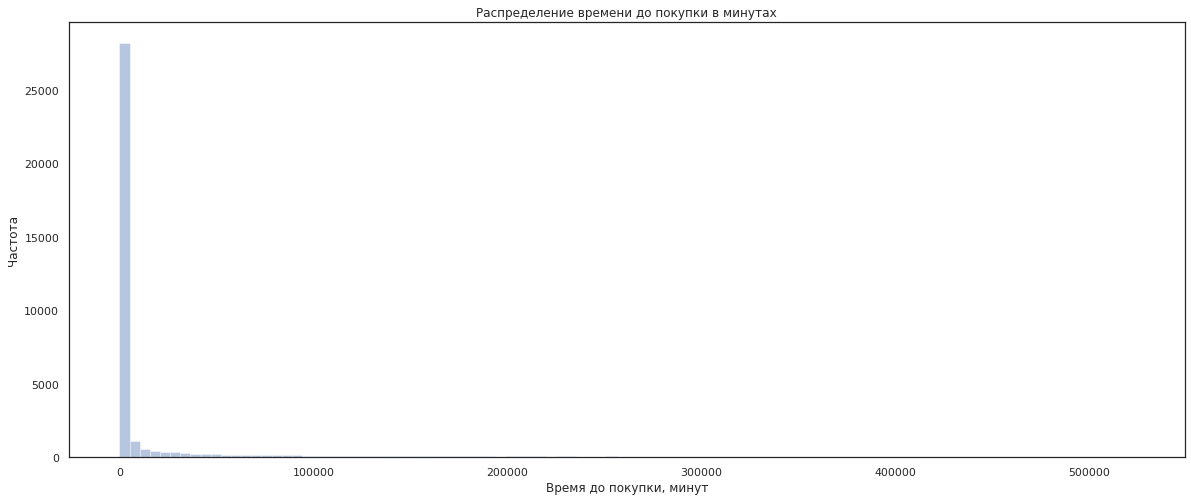

In [44]:
# <Создаем столбец с продолжительностью сессии на сайте в секундах>

plt.figure(figsize=(20, 8))
sns.distplot(buyers_time_to_buy['time_to_buy_minutes'], kde = False, bins = 100)
plt.title('Распределение времени до покупки в минутах')
plt.ylabel('Частота')
plt.xlabel('Время до покупки, минут')
plt.show()

In [45]:
buyers_time_to_buy['time_to_buy_minutes'].median()

16.0

In [46]:
buyers_time_to_buy['time_to_buy_minutes'].median()*60

960.0

С момента первого захода на сайт до совершения покупки в среднем проходит 16 минут или 960 секунд

#### Применяя когортный анализ или другой метод, рассчитайте среднее количество покупок на одного покупателя за определённый период, например за 6 месяцев. Изучать изменение этой метрики во времени необязательно

In [47]:
# <Находим первый месяц покупки>

first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

first_orders

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01
...,...,...
36517,18445147675727495770,2017-11-01
36518,18445407535914413204,2017-09-01
36519,18445601152732270159,2018-03-01
36520,18446156210226471712,2018-02-01


In [48]:
# <Группируем по первому месяцу покупки и считаем сколько пользователей совершили покупки>

cohort_sizes = first_orders.groupby(['first_order_month']).agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [49]:
# <Группируем по первому месяцу покупки и месяцу покупки и считаем количество заказов в месяц>

orders_new = pd.merge(orders, first_orders, on='uid')

cohorts = (orders_new.groupby(['first_order_month', 'order_month'])
               .agg({'revenue': ['sum', 'count']})
               .reset_index())
cohorts.columns = ['first_order_month', 'order_month', 'revenue_sum', 'revenue_count' ]
cohorts


,first_order_month,order_month,revenue_sum,revenue_count
0,2017-06-01,2017-06-01,9557.49,2354
1,2017-06-01,2017-07-01,981.82,177
2,2017-06-01,2017-08-01,885.34,174
3,2017-06-01,2017-09-01,1931.30,226
4,2017-06-01,2017-10-01,2068.58,292
...,...,...,...,...
73,2018-03-01,2018-04-01,1063.05,178
74,2018-03-01,2018-05-01,1114.87,176
75,2018-04-01,2018-04-01,10600.69,2495
76,2018-04-01,2018-05-01,1209.92,195


In [50]:
# <Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц> 
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report['average_purchases'] = report['revenue_count']  / report['n_buyers']

In [51]:
# <Создаем столбец age с возрастом когорты>
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report

,first_order_month,n_buyers,order_month,revenue_sum,revenue_count,average_purchases,age
0,2017-06-01,2023,2017-06-01,9557.49,2354,1.163618,0
1,2017-06-01,2023,2017-07-01,981.82,177,0.087494,1
2,2017-06-01,2023,2017-08-01,885.34,174,0.086011,2
3,2017-06-01,2023,2017-09-01,1931.30,226,0.111715,3
4,2017-06-01,2023,2017-10-01,2068.58,292,0.144340,4
...,...,...,...,...,...,...,...
73,2018-03-01,3533,2018-04-01,1063.05,178,0.050382,1
74,2018-03-01,3533,2018-05-01,1114.87,176,0.049816,2
75,2018-04-01,2276,2018-04-01,10600.69,2495,1.096221,0
76,2018-04-01,2276,2018-05-01,1209.92,195,0.085677,1


In [52]:
# <Создаем сводную таблицу: среднее количество покупок на одного покупателя за определённый период>
output_average_purchases = report.pivot_table(index='first_order_month', columns='age', values='average_purchases', aggfunc='mean').cumsum(axis=1)
output_average_purchases.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.163618,1.25111,1.33712,1.44884,1.59318,1.70094,1.83737,1.92338,2.02818,2.10381,2.15126,2.19377
2017-07-01,1.136765,1.18877,1.25117,1.30525,1.34269,1.38534,1.41706,1.44306,1.47322,1.4857,1.51326,
2017-08-01,1.118978,1.19781,1.2708,1.32993,1.39197,1.43723,1.47299,1.52993,1.5635,1.59708,,
2017-09-01,1.136381,1.22123,1.28361,1.34715,1.37311,1.41534,1.45719,1.47888,1.50252,,,
2017-10-01,1.143779,1.21613,1.25346,1.28157,1.31129,1.33502,1.35484,1.38364,,,,
2017-11-01,1.179368,1.27665,1.32124,1.37295,1.40627,1.42073,1.44572,,,,,
2017-12-01,1.152635,1.21424,1.26032,1.30116,1.32078,1.34474,,,,,,
2018-01-01,1.121554,1.18796,1.2351,1.25408,1.2772,,,,,,,
2018-02-01,1.121611,1.18242,1.20515,1.22432,,,,,,,,


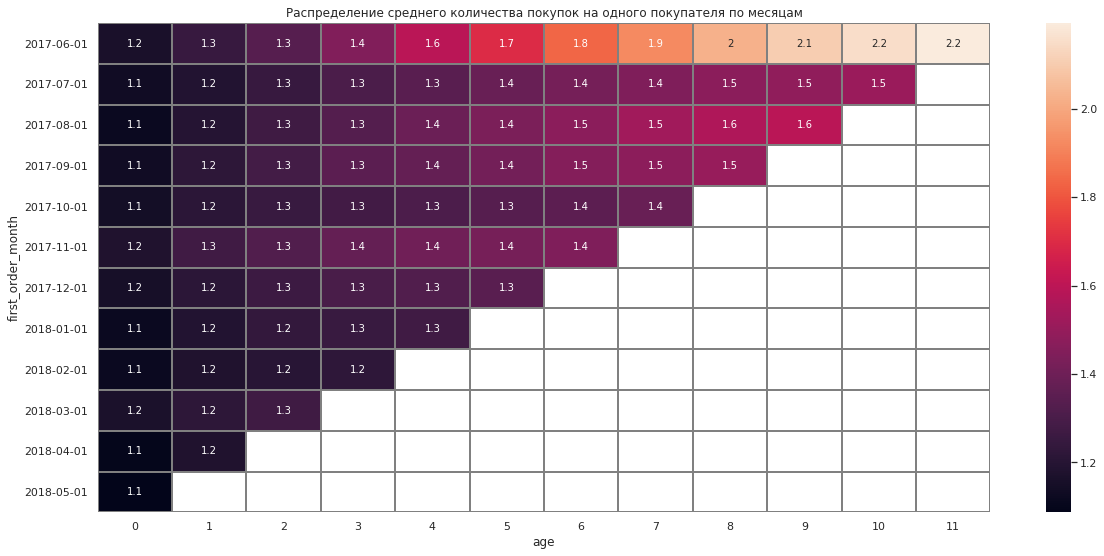

In [53]:
sns.set(style='white')
plt.figure(figsize=(20, 9))
plt.title('Распределение среднего количества покупок на одного покупателя по месяцам')
sns.heatmap(output_average_purchases, annot=True, 
            annot_kws={"fontsize":10}, 
            linewidths=1, 
            linecolor='gray',
           yticklabels=retention_pivot.index.strftime('%Y-%m-%d'))

In [54]:
# <среднее количество покупок на одного покупателя c продолжительностью жизни когорты в 6 месяцев>
output_average_purchases[6].mean()

1.4975282598152309

Таким образом, среднее количество заказов на одного человека за 6 месяцев (по медиане) равно 1.4975

#### Рассчитайте средний чек, применяя группировку по времени совершения покупки. Когортный анализ не подходит — он может исказить расчёты. Постройте график, отражающий изменения метрики во времени

In [55]:
# <Считаем средний чек, суммируя прибыль по месяцам, делим на кол-во заказов>

revenue_per_user = orders.groupby('order_month').agg({'order_date': 'count', 'revenue': 'sum'}).reset_index()
revenue_per_user.columns = ['order_month', 'n_orders', 'revenue']
revenue_per_user['revenue_per_user'] = revenue_per_user['revenue'] / revenue_per_user['n_orders']

revenue_per_user

,order_month,n_orders,revenue,revenue_per_user
0,2017-06-01,2354,9557.49,4.060106
1,2017-07-01,2363,12539.47,5.306589
2,2017-08-01,1807,8758.78,4.847139
3,2017-09-01,3387,18345.51,5.416448
4,2017-10-01,5679,27987.70,4.928280
5,2017-11-01,5659,27069.93,4.783518
6,2017-12-01,6218,36388.60,5.852139
7,2018-01-01,4721,19417.13,4.112927
8,2018-02-01,5281,25560.54,4.840095
9,2018-03-01,5326,28834.59,5.413930


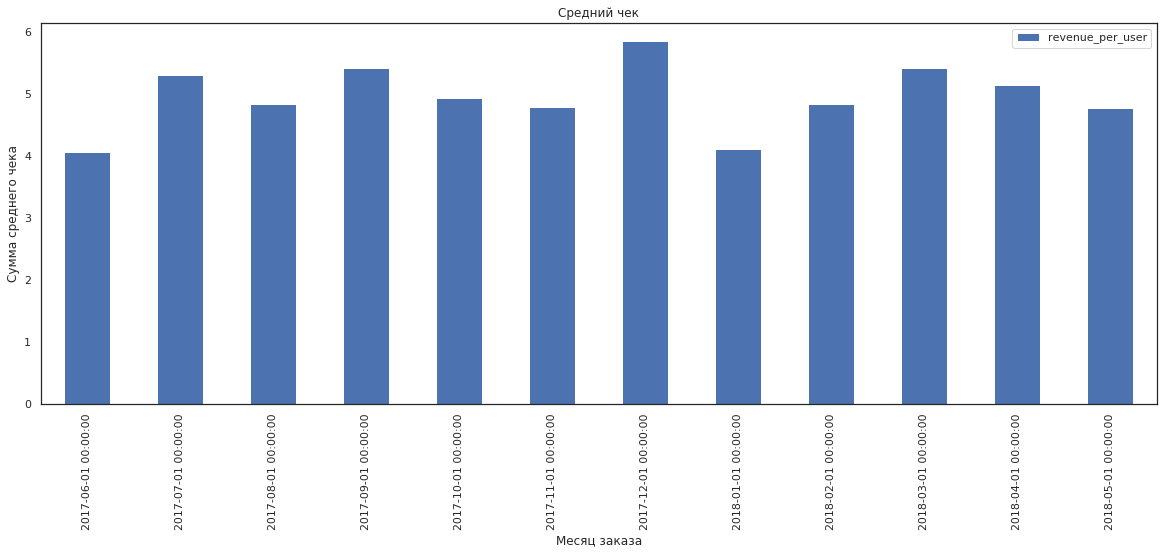

In [56]:
revenue_per_user.plot(kind='bar', x='order_month', y='revenue_per_user', title='Средний чек', figsize=(20, 7))
plt.ylabel('Сумма среднего чека')
plt.xlabel('Месяц заказа')
plt.show()

In [57]:
orders['revenue'].mean()

4.9996782639742925

Общий средний чек равен: 5 у.е.

Наибольший средний чек в декабре, наименьший - в июне

#### Выясните, как меняется LTV на покупателя по когортам. Помните, что LTV — накопительная метрика. Рассчитайте средний LTV по когортам за 6 месяцев; в расчёт включайте когорты, «прожившие» не менее 6 месяцев. Маржинальность сервиса — 100%. Отразите изменения метрики во времени на графике

In [58]:
# <LTV считают не из выручки, а из валовой прибыли. Находим валовую прибыль, умножив выручку на маржинальность>

margin_rate = 1
report['gp'] = report['revenue_sum'] * margin_rate

In [59]:
# <Создаем столбец LTV - итоговую сумму денег, которую один клиент приносит в среднем со всех своих покупок>
report['ltv'] = report['gp'] / report['n_buyers']

report

,first_order_month,n_buyers,order_month,revenue_sum,revenue_count,average_purchases,age,gp,ltv
0,2017-06-01,2023,2017-06-01,9557.49,2354,1.163618,0,9557.49,4.724414
1,2017-06-01,2023,2017-07-01,981.82,177,0.087494,1,981.82,0.485329
2,2017-06-01,2023,2017-08-01,885.34,174,0.086011,2,885.34,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,226,0.111715,3,1931.30,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,292,0.144340,4,2068.58,1.022531
...,...,...,...,...,...,...,...,...,...
73,2018-03-01,3533,2018-04-01,1063.05,178,0.050382,1,1063.05,0.300892
74,2018-03-01,3533,2018-05-01,1114.87,176,0.049816,2,1114.87,0.315559
75,2018-04-01,2276,2018-04-01,10600.69,2495,1.096221,0,10600.69,4.657597
76,2018-04-01,2276,2018-05-01,1209.92,195,0.085677,1,1209.92,0.531599


In [60]:
output_ltv = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean').cumsum(axis=1)#.round()

output_ltv.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,5.20974,5.64738,6.60205,7.62458,8.36008,9.31052,9.89212,10.4453,11.0511,11.6224,11.8792
2017-07-01,6.010218,6.34543,6.96896,7.32794,7.50473,7.66077,7.78098,7.9228,8.08404,8.23118,8.38685,
2017-08-01,5.276518,5.74851,6.20699,6.59827,7.09232,7.37586,7.58653,7.99153,8.28374,8.47172,,
2017-09-01,5.644529,6.76212,7.28305,11.2588,11.6594,12.3065,13.0081,13.2512,13.4352,,,
2017-10-01,5.003733,5.5395,5.73089,5.88803,6.03959,6.15996,6.24477,6.36024,,,,
2017-11-01,5.154683,5.55392,5.75347,6.07842,6.22644,6.28032,6.39524,,,,,
2017-12-01,4.738191,4.99856,5.92366,6.98894,7.30187,7.63991,,,,,,
2018-01-01,4.135636,4.43039,4.73468,4.87745,4.94015,,,,,,,
2018-02-01,4.156987,4.43526,4.51378,4.58792,,,,,,,,


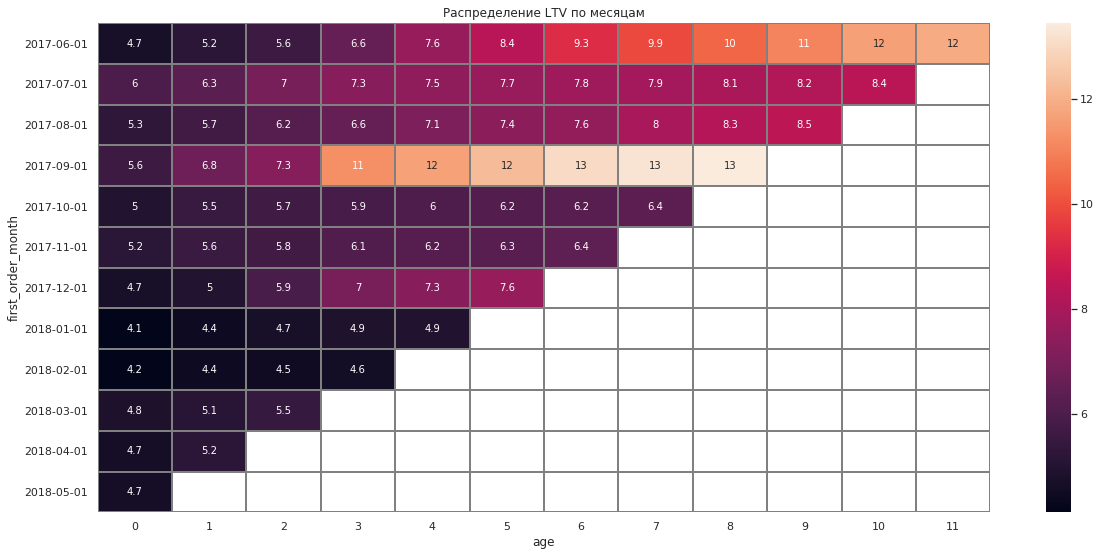

In [61]:
sns.set(style='white')
plt.figure(figsize=(20, 9))
plt.title('Распределение LTV по месяцам')
sns.heatmap(output_ltv, annot=True, annot_kws={"fontsize":10}, linewidths=1, linecolor='gray', yticklabels=retention_pivot.index.strftime('%Y-%m-%d'))

In [62]:
output_ltv[6].describe()

count     6.000000
mean      8.387686
std       2.520771
min       6.244772
25%       6.693064
50%       7.683754
75%       8.928139
max      13.008071
Name: 6, dtype: float64

Средний накопительный LTV за 6 месяцев жизни когорт равен по медиане 7.68

### Маркетинговые метрики <a id="marketing_metrics"></a>

#### Посчитайте общую сумму расходов на маркетинг. Выясните, как траты распределены по источникам. Визуализируйте изменения метрик во времени

In [63]:
costs['costs'].sum()

329131.62

Общая сумма расходов на маркетинг составляет 329131.62 у.е.

In [64]:
costs['costs_month'] = costs['dt'].astype('datetime64[M]')
costs['costs_year']  = costs['dt'].astype('datetime64[Y]')

costs['costs_month_count'] = costs['dt'].dt.month
costs['costs_year_count'] = costs['dt'].dt.year
costs

,source_id,dt,costs,costs_month,costs_year,costs_month_count,costs_year_count
0,1,2017-06-01,75.20,2017-06-01,2017-01-01,6,2017
1,1,2017-06-02,62.25,2017-06-01,2017-01-01,6,2017
2,1,2017-06-03,36.53,2017-06-01,2017-01-01,6,2017
3,1,2017-06-04,55.00,2017-06-01,2017-01-01,6,2017
4,1,2017-06-05,57.08,2017-06-01,2017-01-01,6,2017
...,...,...,...,...,...,...,...
2537,10,2018-05-27,9.92,2018-05-01,2018-01-01,5,2018
2538,10,2018-05-28,21.26,2018-05-01,2018-01-01,5,2018
2539,10,2018-05-29,11.32,2018-05-01,2018-01-01,5,2018
2540,10,2018-05-30,33.15,2018-05-01,2018-01-01,5,2018


In [65]:
# <Создаем сводную по затратам на маркетинг на разных источниках>
source_pivot = costs.pivot_table(
    index = 'source_id', columns = 'costs_month', values = 'costs', aggfunc = 'sum')
source_pivot

costs_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
source_id,,,,,,,,,,,,
1,1125.61,1072.88,951.81,1502.01,2315.75,2445.16,2341.20,2186.18,2204.48,1893.09,1327.49,1467.61
2,2427.38,2333.11,1811.05,2985.66,4845.00,5247.68,4897.80,4157.74,4474.34,3943.14,2993.70,2689.44
3,7731.65,7674.37,6143.54,9963.55,15737.24,17025.34,16219.52,14808.78,14228.56,13080.85,9296.81,9411.42
4,3514.80,3529.73,3217.36,5192.26,6420.84,5388.82,7680.47,5832.79,5711.96,5961.87,4408.49,4214.21
5,2616.12,2998.14,2185.28,3849.14,5767.40,6325.34,5872.52,5371.52,5071.31,4529.62,3501.15,3669.56
9,285.22,302.54,248.93,415.62,609.41,683.18,657.98,547.16,551.50,480.29,373.49,362.17
10,314.22,329.82,232.57,460.67,627.24,792.36,645.86,614.35,480.88,526.41,388.25,409.86


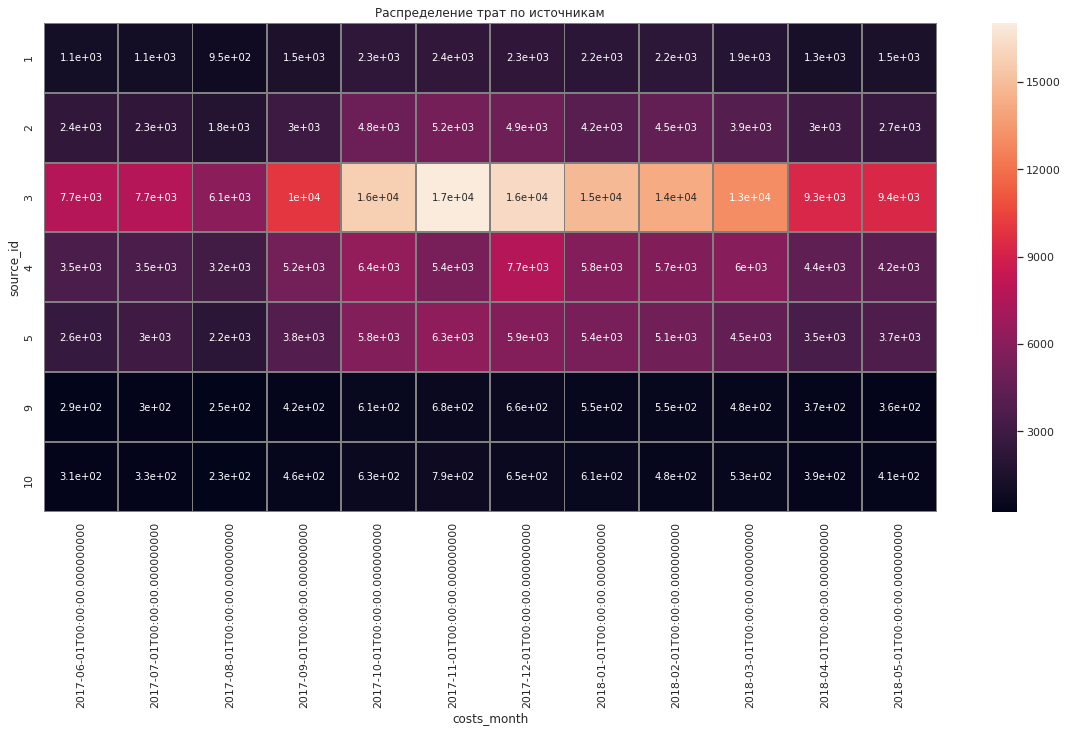

In [66]:
sns.set(style='white')
plt.figure(figsize=(20, 9))
plt.title('Распределение трат по источникам')
sns.heatmap(source_pivot, annot=True, annot_kws={"fontsize":10}, linewidths=1, linecolor='gray');

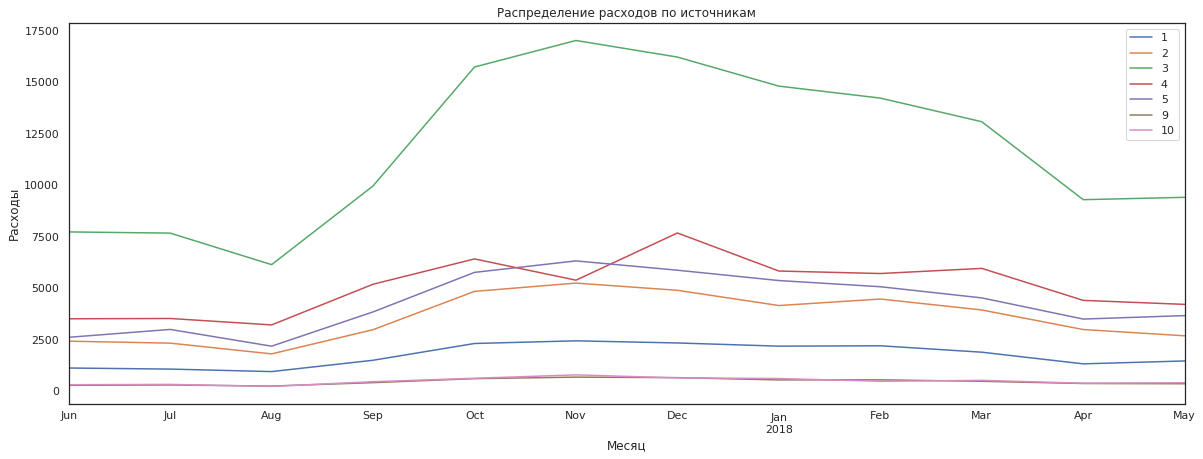

In [67]:
# <График распределения расходов по источникам>
source_pivot_2 = costs.pivot_table(
    index = 'costs_month', columns = 'source_id', values = 'costs', aggfunc = 'sum')
source_pivot_2.plot(title='Распределение расходов по источникам', figsize=(20, 7))
plt.legend(loc='best')
plt.ylabel('Расходы')
plt.xlabel('Месяц')
plt.show()

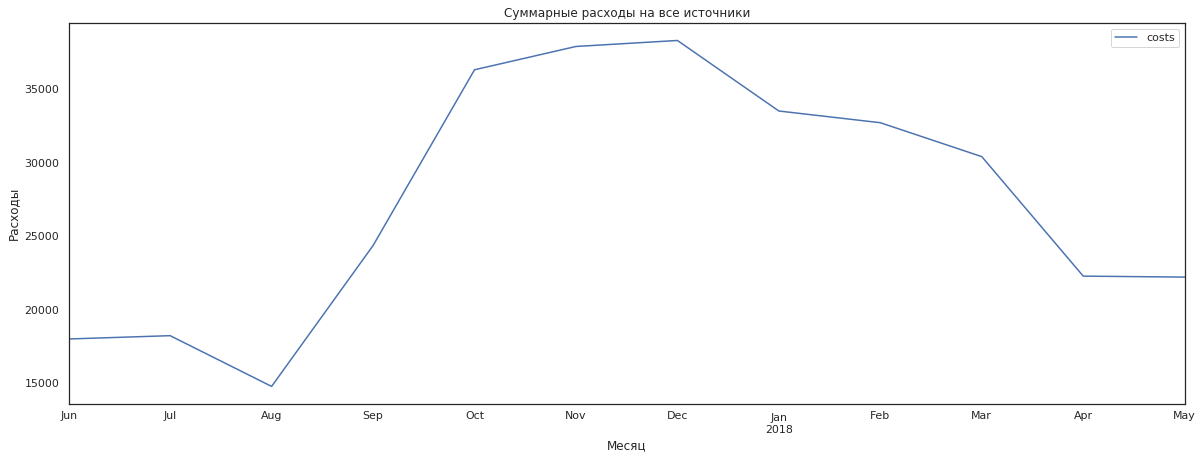

In [68]:
# <График суммарных расходов по всем источникам>
all_source_pivot = costs.pivot_table(
    index = 'costs_month', values = 'costs', aggfunc = 'sum')
all_source_pivot.plot(title='Суммарные расходы на все источники', figsize = (20,7))
plt.ylabel('Расходы')
plt.xlabel('Месяц')
plt.show()

Меньше всего трат на маркетинг уходит на источники 9 и 10, больше всего трат - на источник 3

На графике суммарных расходов на все источники наблюдается спад затрат в летний сезон и повышение затрат в зимний

#### Рассчитайте средний CAC на одного покупателя для всего проекта и для каждого источника трафика. Отразите изменения метрик на графиках

In [69]:
# Составляем таблицу byuers и находим первый источник каждого пользователя

first_visits_buyers = visits.groupby('uid').agg({'start_ts': 'min'}).reset_index()
first_visits_buyers.columns = ['uid', 'first_session_start_ts']

first_visits_buyers['first_session_date'] = first_visits_buyers['first_session_start_ts'].astype('datetime64[D]')
first_visits_buyers['first_session_month'] = first_visits_buyers['first_session_start_ts'].astype('datetime64[M]')

first_orders_buyers = orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
first_orders_buyers.columns = ['uid', 'first_order_buy_ts']

#first_orders_buyers['first_order_date'] = first_orders_buyers['first_order_buy_ts'].dt.date
first_orders_buyers['first_order_date'] = first_orders_buyers['first_order_buy_ts'].astype('datetime64[D]')
first_orders_buyers['first_order_month'] = first_orders_buyers['first_order_date'].astype('datetime64[M]')

buyers = pd.merge(first_visits_buyers, first_orders_buyers, on='uid', how = 'outer')

users = visits.sort_values('start_ts').groupby('uid').first().reset_index()
users = users[['uid', 'source_id']]
users.columns = ['uid', 'first_source_id']

buyers = pd.merge(buyers, users, on='uid')
buyers

,uid,first_session_start_ts,first_session_date,first_session_month,first_order_buy_ts,first_order_date,first_order_month,first_source_id
0,11863502262781,2018-03-01 17:27:00,2018-03-01,2018-03-01,NaT,NaT,NaT,3
1,49537067089222,2018-02-06 15:55:00,2018-02-06,2018-02-01,NaT,NaT,NaT,2
2,297729379853735,2017-06-07 18:47:00,2017-06-07,2017-06-01,NaT,NaT,NaT,3
3,313578113262317,2017-09-18 22:49:00,2017-09-18,2017-09-01,2018-01-03 21:51:00,2018-01-03,2018-01-01,2
4,325320750514679,2017-09-30 14:29:00,2017-09-30,2017-09-01,NaT,NaT,NaT,5
...,...,...,...,...,...,...,...,...
228127,18446403737806311543,2017-11-30 03:36:00,2017-11-30,2017-11-01,NaT,NaT,NaT,5
228128,18446424184725333426,2017-12-06 20:32:00,2017-12-06,2017-12-01,NaT,NaT,NaT,4
228129,18446556406699109058,2018-01-01 16:29:00,2018-01-01,2018-01-01,NaT,NaT,NaT,3
228130,18446621818809592527,2017-12-27 13:27:00,2017-12-27,2017-12-01,NaT,NaT,NaT,4


In [70]:
buyers_daily = buyers.groupby(['first_source_id', 'first_order_date']).agg({'uid': 'count'}).reset_index()
buyers_daily.rename(columns={'uid': 'n_buyers'}, inplace=True)
buyers_daily

,first_source_id,first_order_date,n_buyers
0,1,2017-06-01,14
1,1,2017-06-02,7
2,1,2017-06-03,7
3,1,2017-06-04,3
4,1,2017-06-05,18
...,...,...,...
2428,10,2018-05-27,2
2429,10,2018-05-28,10
2430,10,2018-05-29,7
2431,10,2018-05-30,5


In [71]:
costs = pd.merge(buyers_daily, costs, left_on=['first_source_id', 'first_order_date'], right_on=['source_id', 'dt'])
costs

,first_source_id,first_order_date,n_buyers,source_id,dt,costs,costs_month,costs_year,costs_month_count,costs_year_count
0,1,2017-06-01,14,1,2017-06-01,75.20,2017-06-01,2017-01-01,6,2017
1,1,2017-06-02,7,1,2017-06-02,62.25,2017-06-01,2017-01-01,6,2017
2,1,2017-06-03,7,1,2017-06-03,36.53,2017-06-01,2017-01-01,6,2017
3,1,2017-06-04,3,1,2017-06-04,55.00,2017-06-01,2017-01-01,6,2017
4,1,2017-06-05,18,1,2017-06-05,57.08,2017-06-01,2017-01-01,6,2017
...,...,...,...,...,...,...,...,...,...,...
2428,10,2018-05-27,2,10,2018-05-27,9.92,2018-05-01,2018-01-01,5,2018
2429,10,2018-05-28,10,10,2018-05-28,21.26,2018-05-01,2018-01-01,5,2018
2430,10,2018-05-29,7,10,2018-05-29,11.32,2018-05-01,2018-01-01,5,2018
2431,10,2018-05-30,5,10,2018-05-30,33.15,2018-05-01,2018-01-01,5,2018


In [72]:
# <Считаем САС - стоимость привлечения клиента. Сумма денег, во сколько обходится новый клиент компании.>
costs['cac'] = costs['costs']/costs['n_buyers']
costs

,first_source_id,first_order_date,n_buyers,source_id,dt,costs,costs_month,costs_year,costs_month_count,costs_year_count,cac
0,1,2017-06-01,14,1,2017-06-01,75.20,2017-06-01,2017-01-01,6,2017,5.371429
1,1,2017-06-02,7,1,2017-06-02,62.25,2017-06-01,2017-01-01,6,2017,8.892857
2,1,2017-06-03,7,1,2017-06-03,36.53,2017-06-01,2017-01-01,6,2017,5.218571
3,1,2017-06-04,3,1,2017-06-04,55.00,2017-06-01,2017-01-01,6,2017,18.333333
4,1,2017-06-05,18,1,2017-06-05,57.08,2017-06-01,2017-01-01,6,2017,3.171111
...,...,...,...,...,...,...,...,...,...,...,...
2428,10,2018-05-27,2,10,2018-05-27,9.92,2018-05-01,2018-01-01,5,2018,4.960000
2429,10,2018-05-28,10,10,2018-05-28,21.26,2018-05-01,2018-01-01,5,2018,2.126000
2430,10,2018-05-29,7,10,2018-05-29,11.32,2018-05-01,2018-01-01,5,2018,1.617143
2431,10,2018-05-30,5,10,2018-05-30,33.15,2018-05-01,2018-01-01,5,2018,6.630000


In [73]:
costs_pivot = costs.pivot_table(index=['costs_year', 'costs_month'], 
                                columns='first_source_id', values='cac', 
                                aggfunc='mean')
costs_pivot

first_source_id                1          2          3          4          5   \
costs_year costs_month                                                          
2017-01-01 2017-06-01   11.681283  12.883568  16.716919  10.792094   9.209676   
           2017-07-01    9.491485  18.000253  18.593952   8.054482   7.938157   
           2017-08-01   12.118898  18.886449  19.795068  11.554926   6.879620   
           2017-09-01    8.155731  17.672249  13.084043   9.533800   6.864844   
           2017-10-01    8.202083  14.193003  14.613088   6.233562   6.305969   
           2017-11-01    8.908503  17.437690  16.091445   5.013132   9.368019   
           2017-12-01    8.570439  13.871086  12.948321   5.656507   8.399174   
2018-01-01 2018-01-01   11.719181  15.850151  15.134989   5.901092   9.371755   
           2018-02-01   10.752216  18.209325  13.894612   5.428068   7.725369   
           2018-03-01    8.021974  16.122180  15.563841   6.753624  10.309222   
           2018-04-01    8.584114  17.648538  15.961657   6.567086   9.631068   
           2018-05-01    7.851694  14.994208  14.401278   5.628901   8.139812   

first_source_id               9          10  
costs_year costs_month                       
2017-01-01 2017-06-01   5.253654   4.590158  
           2017-07-01   5.582433   6.151880  
           2017-08-01   4.900254   5.813398  
           2017-09-01   6.049126   8.306581  
           2017-10-01   5.923235   6.362921  
           2017-11-01   9.400503  10.801337  
           2017-12-01   7.899420   7.803197  
2018-01-01 2018-01-01   9.792713   9.851557  
           2018-02-01   8.181382   4.489624  
           2018-03-01   5.312877   4.233605  
           2018-04-01   6.491157   4.394415  
           2018-05-01   6.506049   5.176317

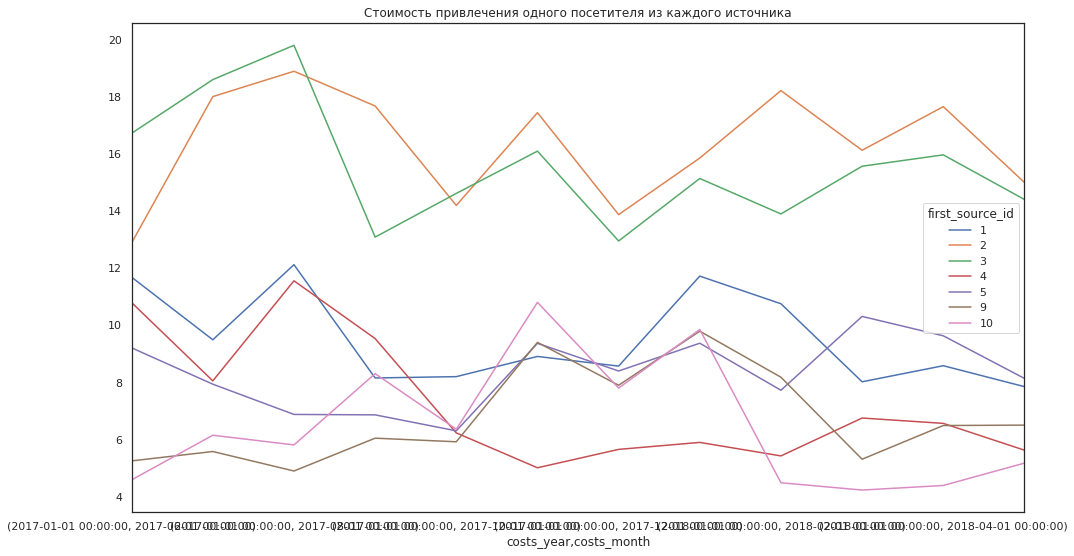

In [74]:
costs_pivot.plot(figsize=(16,9),title='Стоимость привлечения одного посетителя из каждого источника')

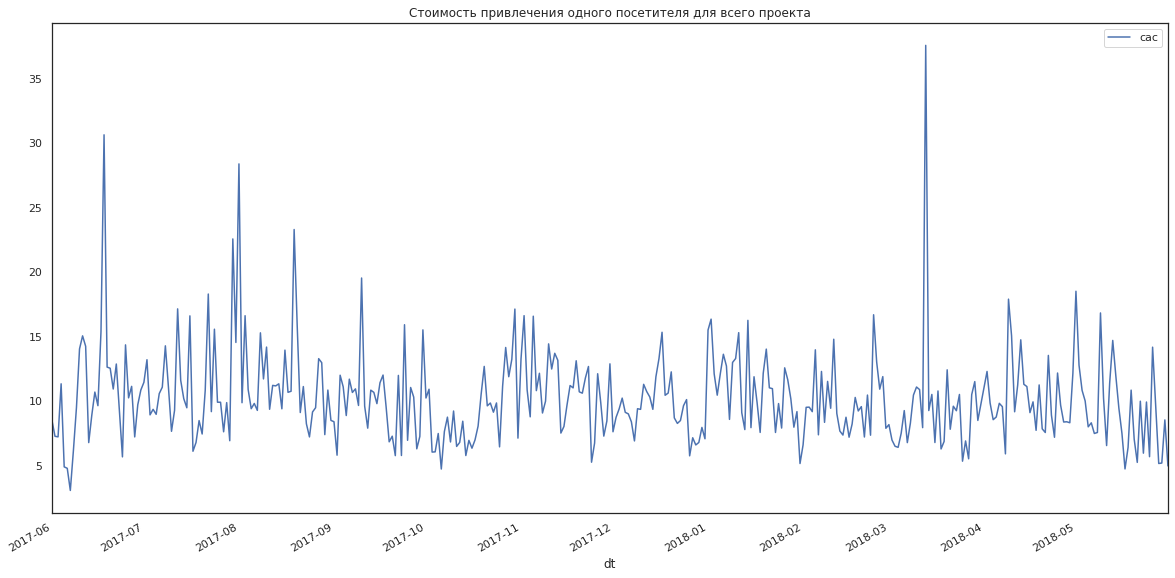

In [75]:
costs_pivot_2 = costs.pivot_table(index='dt', 
                                  values='cac', 
                                  aggfunc='mean')
costs_pivot_2.plot(figsize=(20,10), title='Стоимость привлечения одного посетителя для всего проекта')

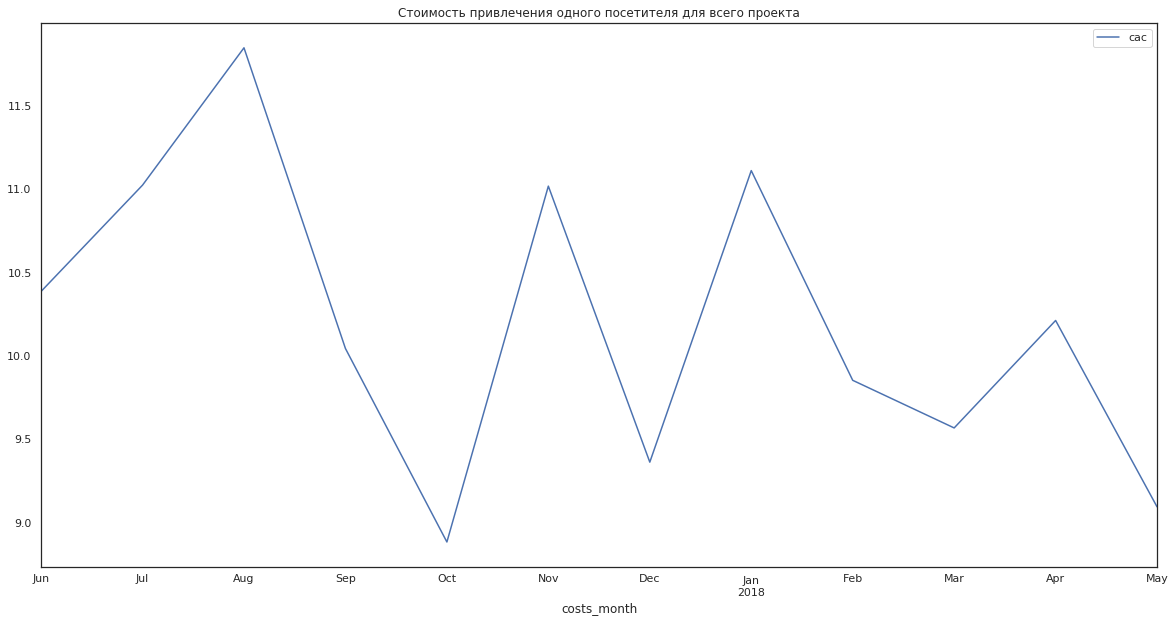

In [76]:
costs_pivot_3 = costs.pivot_table(index='costs_month', 
                                  values='cac', 
                                  aggfunc='mean')
costs_pivot_3.plot(figsize=(20,10), title='Стоимость привлечения одного посетителя для всего проекта')

In [77]:
# <Средний CAC для всего проекта>
costs['cac'].mean()

10.193254970693388

In [78]:
costs_per_buyer = costs.groupby('source_id')[['cac']].describe()
costs_per_buyer

cac                                                        \
           count       mean        std       min        25%        50%   
source_id                                                                
1          361.0   9.489732   7.323941  1.531429   5.158750   7.561429   
2          362.0  16.287024  11.634601  1.435876  10.050972  13.310417   
3          363.0  15.580474   7.867573  2.412727  10.530686  14.503333   
4          362.0   7.271743   6.777558  0.028621   2.526983   5.508686   
5          363.0   8.336731   3.946010  2.780909   5.848098   7.468182   
9          302.0   6.842532   5.107688  0.473488   3.366250   5.512500   
10         320.0   6.555415   6.013867  0.180000   2.504286   4.800000   

                                  
                 75%         max  
source_id                         
1          11.282857   53.530000  
2          19.033750  118.270000  
3          18.957233   71.543333  
4          10.021972   61.586667  
5           9.930114   38.670000  
9           8.403750   31.750000  
10          8.223125   36.770000

In [79]:
cac = costs_per_buyer['cac']['mean']
cac.sort_values()

source_id
10     6.555415
9      6.842532
4      7.271743
5      8.336731
1      9.489732
3     15.580474
2     16.287024
Name: mean, dtype: float64

Дороже всего стоимость привлечения клиента в августе, в мае - дешевле всего

Дороже всего покупатели, привлекаемые через 2 и 3 источники

Дешевле всего покупатели, привлекаемые через 10, 9 и 4 источники

Средний CAC для всего проекта равен 10.19

#### Рассчитайте ROMI по когортам в разрезе источников. Сравните окупаемость за одинаковые периоды жизни когорт. Обратите внимание, что клиенты, пришедшие из разных источников, могут иметь разный LTV. Постройте графики, отражающие изменения метрик во времени

In [80]:
ltv = {}

for source, df in buyers.groupby('first_source_id'):
    #print(source, df.shape)

    cohort_sizes = df.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
    cohort_sizes.columns = ['first_order_month', 'n_buyers']

    cohorts = pd.merge(orders, df, on='uid')
    cohorts = cohorts.groupby(['first_order_month', 'order_month']).agg({'revenue': ['sum', 'count']}).reset_index()

    cohorts['age_month'] = ((cohorts['order_month'] - cohorts['first_order_month']) / np.timedelta64(1,'M')).round()
    cohorts.columns = ['first_order_month', 'order_month', 'revenue', 'n_orders', 'age_month']

    cohorts_report = pd.merge(cohort_sizes, cohorts, on = 'first_order_month')
    cohorts_report['ltv'] = cohorts_report['revenue'] / cohorts_report['n_buyers']
    cohorts_report['orders_per_buyer'] = cohorts_report['n_orders'] / cohorts_report['n_buyers']

    cohorts_age = cohorts_report.pivot_table(
        index='first_order_month', 
        columns='age_month', 
        values='ltv', 
        aggfunc='sum'
    ).cumsum(axis=1)
    
    
    ltv[source] = cohorts_age[8].mean()


roi = {k:ltv[k]/v for k,v in cac.items()}
roi

{1: 2.0126955933529667,
 2: 0.9180584744251358,
 3: 0.41406209944039396,
 4: 1.0378930762011966,
 5: 1.5860754718810741,
 9: 1.064229435968639,
 10: 0.44869894065585486}

- Первый источник окупается на 4ый месяц проекта
- Пятый источник окупается на 5ый месяц проекта

На 9ый месяц проекта также окупаются источники 4 и 9

Остальные источники не окупаются на 9ый месяц проекта

## Выводы и рекомендации<a id="total"></a>

### Определите источники трафика, на которые маркетологам стоит делать упор. Объясните свой выбор: на какие метрики вы ориентируетесь и почему

Ориентируемся на сумму расходов на маркетинг по источникам и CAC по источникам:
- следует обратить внимание на источник номер 3 - стоимость привлечения одного клиента в разы больше, чем у остальных источников, возможно, бюджет стоит перераспределить

Ориентируемся на ROMI:
- возможно, следует направить больше затрат на маркетинг на источники 1, 4, 5, 9 - их ROMI больше, чем у остальных источников, то есть они быстрее окупаются

### Опишите выводы, которые вы сделали после подсчёта метрик каждого вида: маркетинговых, продуктовых и метрик электронной коммерции

Продуктовые метрики:
- В день - 908 уникальных пользователей (в среднем)
- В неделю - 5716 уникальных пользователей (в среднем)
- В месяц - 23228 уникальных пользователей (в среднем)
- Пик уникальных пользователей в день приходится на 2017-11-24, возможно, это связано с тем, что в 2017 году этот день являлся  черной пятницей

- В среднем уникальные пользователи посещают сайт 1 раз в день, повторно на сайт пользователи не заходят.
- Средняя продолжительность сессии равна 5 минутам или 300 секундам
- Показатель удержания пользователей за второй месяц жизни когорт равен 6.5%, и он больше среднего показателя Retention Rate по остальным когортам, показатель Retention Rate снижается со временем

Маркетинговые метрики:
- Общая сумма затрат на маркетинг равна 329132
- Меньше всего трат на маркетинг уходит на источники 9 и 10, больше всего трат - на источник 3
- Наблюдается спад суммарных затрат на все источники в летний сезон и повышение затрат в зимний
- Дороже всего стоимость привлечения клиента в августе, в мае - дешевле всего
- Средняя стоимость привлечения одного клиента по всем источникам равна 10.2 у.е.
- Средняя стоимость привлечения одного клиента по каждому из источников:
        10     6.555415
        9      6.842532
        4      7.271743
        5      8.336731
        1      9.489732
        3     15.580474
        2     16.287024
- Наименее дорогие источники - 10 и 9
- Наиболее дорогие - 3 и 2 источники
- Затраты на первый источник окупаются на 4ый месяц проекта
- Затраты на пятый источник окупаются на 5ый месяц проекта
- На 9ый месяц проекта окупаются затраты на источники 4 и 9


Метрики электронной коммерции:
- С момента первого захода на сайт до совершения покупки в среднем проходит 16 минут, в основном покупки совершаются в первый же день
- Среднее количество заказов на одного человека за 6 месяцев (по медиане) равно 1,5
- Общий средний чек равен: 5 у.е.
- Наибольший средний чек в декабре, наименьший - в июне
- Валовая прибыль на 6 месяц жизни когорт (LTV) равна в среднем 7,68

### Подведите итоги когортного анализа. Определите самые перспективные для компании когорты клиентов

Наиболее перспективными являются две первые когорты, их retention rate почти в 2 раза больше, чем у остальных когорт

Также следует обратить внимание на когорты 3, 4 и 7 - их ltv выше чем у всех остальных когорт.